## L1 Regularization In Practice

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns

df_iris = sns.load_dataset("iris")

In [3]:
from sklearn.preprocessing import LabelEncoder
#transformamos las etiquetas (y) de los datos a ser números desde 0 a n_clases-1
label_enc = LabelEncoder()

labels = label_enc.fit_transform(df_iris.species)

X = torch.tensor(df_iris.iloc[:,0:4].values).float() #matriz de características
y = torch.tensor(labels).long() #vector de las etiquetas transformadas a números (tipo de dato long() -> entero) #podiamos tambien haber hecho df.iris[df.iris.species=="setosa"] == 1 y así

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [6]:
batch_size = 16 #suelen ser potencias de 2

train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(test_data,
                        batch_size=test_data.tensors[0].shape[0])
#train_data.tensors[0] accede a las características X
#para predicciones del modelo, los lotes son individuales

<img src="l1 regularization details.jpg" alt="info" width=700>

In [7]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.inp = nn.Linear(4, 64)
        self.hid = nn.Linear(64, 64)
        self.out = nn.Linear(64, 3)
    
    def forward(self, x):
        
        x = F.relu(self.inp(x))
        x = F.relu(self.hid(x))
        x = self.out(x)
        
        return x
        

In [8]:
def create_model():
    
    model = Model()
    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(params=model.parameters(),
                       lr=0.005)
    
    return model, loss_func, optim

### Muestra de cómo acceder a los pesos de la red

La función `model.named_parameters()` devuelve una tupla formada por el (nombre_del_parámetro, parámetro)

- Posición [0] -> nombre
- Posición [1] -> objeto de dicho parámetro

https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_parameters

In [9]:
torch.numel(torch.Tensor([4,4]))

2

In [10]:
example_model = create_model()[0]

print(example_model)
print(" ")

for param in example_model.named_parameters():
    print(f"parameter name: {param[0]}") #nombre_capa.weight o nombre_capa.bias
    print(f"parameter lenght: {param[1].numel()}") #numel() te devuelve la cantidad de elementos (ejemplo de [2,3]= 2)
    print(f"parameter shape: {param[1].shape}")
    print(" ")


Model(
  (inp): Linear(in_features=4, out_features=64, bias=True)
  (hid): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=3, bias=True)
)
 
parameter name: inp.weight
parameter lenght: 256
parameter shape: torch.Size([64, 4])
 
parameter name: inp.bias
parameter lenght: 64
parameter shape: torch.Size([64])
 
parameter name: hid.weight
parameter lenght: 4096
parameter shape: torch.Size([64, 64])
 
parameter name: hid.bias
parameter lenght: 64
parameter shape: torch.Size([64])
 
parameter name: out.weight
parameter lenght: 192
parameter shape: torch.Size([3, 64])
 
parameter name: out.bias
parameter lenght: 3
parameter shape: torch.Size([3])
 


### **Función que entrena el modelo y pone en marcha la regularización L1**

### El coeficiente de penalización $\large\lambda$ estaba formado por $\large{\frac{\alpha}{2\cdot m}}$ 

<img src="l1 coefficient detail.jpg" alt="info" width=300>

Realmente el parámetro ajustable en este caso es $\alpha$, que compone el resultado del coeficiente, pero lo llamaremos $\lambda$

In [11]:
n_weights = sum([param[1].numel() for param in example_model.named_parameters() if "bias" not in param[0]])

In [12]:
n_weights

4544

<img src="l1 extra formula.jpg" alt="info" width=300>

In [25]:
n_epochs = 1000

def train_model(l1_lambda):
    
    train_accs = []
    test_accs = []
    losses = []
    
    #obtenemos el número de pesos entrenables (en este caso sin bias) en cada capa, y los sumamos
    n_weights = sum([param[1].numel() for param in model.named_parameters() if "bias" not in param[0]])    
    
#     n_weights = 0
#     for param_name, param in model.named_parameters():
#         if "bias" not in param_name:
#             n_weights+=param.numel()    

    for epoch in range(n_epochs):
        
        batch_accs = []
        batch_losses = []
        
        for X_batch, y_batch in train_loader:
            
            y_hat = model(X_batch) #forward pass
            
            loss = loss_func(y_hat, y_batch) #measure loss
            
            #añadiendo el término de L1 a la pérdida
            l1_term = torch.tensor(0., requires_grad=True) #inincializará como 0 (requerirá calcular gradiente ya que se suma a la pérdida)
            for param_name, param in model.named_parameters():
                if "bias" not in param_name:
                    l1_term = l1_term + torch.sum(torch.abs(param))
                    #añadirá al término de penalización la suma de los valores absolutos de cada matriz de pesos
            
            loss += l1_lambda*l1_term/n_weights 
            #el término l1_lambda escala hacia abajo la penalización L1
            

            
            optim.zero_grad()
            loss.backward() #compute gradients
            optim.step() #update parameters
            
            batch_accs.append(100*torch.mean((torch.argmax(y_hat,axis=1) == y_batch).float()).item() )
            batch_losses.append(loss.item())
        
        train_accs.append(np.mean(batch_accs))
        losses.append(np.mean(batch_losses))
        
        X_test, y_test = next(iter(test_loader))
        pred_labels = torch.argmax(model(X_test), axis=1)
        test_accs.append(100*torch.mean((pred_labels==y_test).float()).item())
        
    return train_accs, test_accs, losses

### Testeando el modelo

In [26]:
model, loss_func, optim = create_model()

l1_lambda = 0.001

train_accs, test_accs, losses = train_model(l1_lambda)

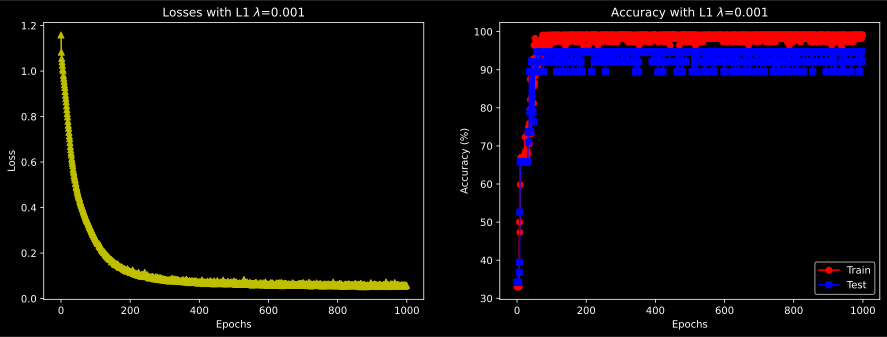

In [30]:
fig,axs = plt.subplots(1,2,figsize=(15,5))


axs[0].plot(losses,'y^-')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Losses with L1 $\lambda$=' + str(l1_lambda))

axs[1].plot(train_accs,'ro-')
axs[1].plot(test_accs,'bs-')
axs[1].set_title('Accuracy with L1 $\lambda$=' + str(l1_lambda))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend(['Train','Test'])

plt.show()

In [31]:
#para el suavizado y mejor visualización de las gráficas
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode="same")

In [35]:
from tqdm import tqdm

In [45]:
exp_train_accs.shape

(1000, 10)

Nota que si el coeficiente $\large\lambda$ es 0, entonces la penalización es nula, teniendo la pérdida sin ninguna modificación de regularización en dicho caso

In [47]:
# valores con los que probaremos
l1_lambda_values = np.linspace(0,.005,10)

exp_train_accs = np.zeros((n_epochs,len(l1_lambda_values)))
exp_test_accs  = np.zeros((n_epochs,len(l1_lambda_values)))


for l1_value in tqdm(range(len(l1_lambda_values))):
    
    model, loss_func, optim = create_model()

    train_accs, test_accs, losses = train_model(l1_lambda_values[l1_value])
    
    #con suavizado
  # exp_train_accs[:,l1_value] = smooth(train_accs,10)
  # exp_test_accs[:,l1_value]  = smooth(test_accs,10)
    exp_train_accs[:,l1_value] = train_accs
    exp_test_accs[:,l1_value]  = test_accs

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.20s/it]


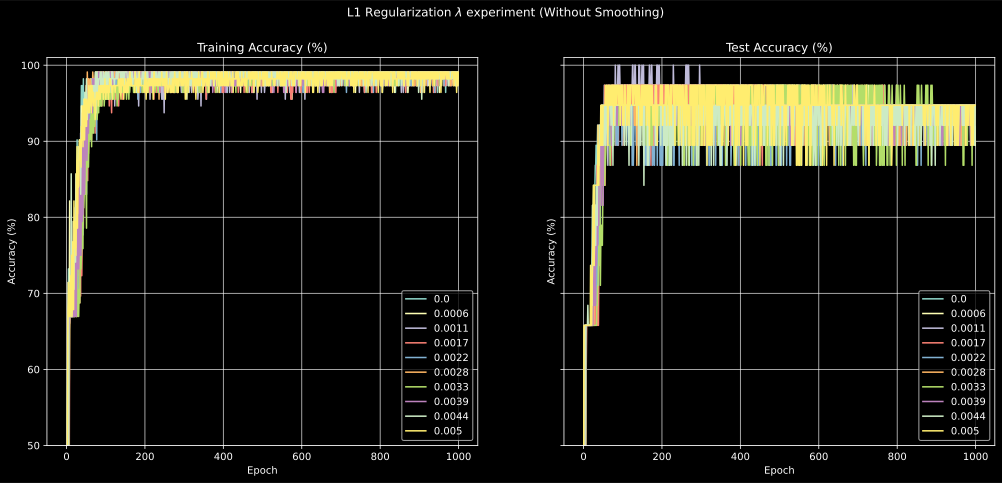

In [54]:
fig, axs = plt.subplots(1,2, figsize=(17,7), sharey=True)

fig.suptitle("L1 Regularization $\lambda$ experiment (Without Smoothing)")
axs[0].plot(exp_train_accs)
axs[0].set_title("Training Accuracy (%)")
axs[1].plot(exp_test_accs)
axs[1].set_title("Test Accuracy (%)")

for i in range(2):
    axs[i].legend(np.round(l1_lambda_values, 4));
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].set_ylim([50, 101])
    axs[i].grid(alpha=0.8);
    
plt.plot();

Focalicemos en el inincio de las epoch para ver que valor de l1 lambda nos da un mejor rendimiento desde epochs tempranas

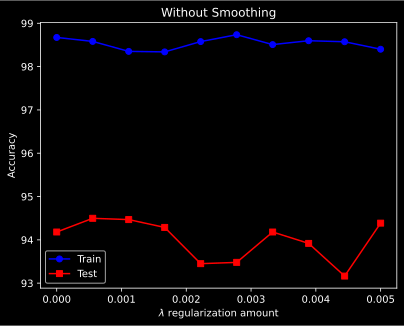

In [55]:
epoch_range = [500,950]


plt.plot(l1_lambda_values,
         np.mean(exp_train_accs[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='Train')

plt.plot(l1_lambda_values,
         np.mean(exp_test_accs[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='Test')

plt.title("Without Smoothing")
plt.xlabel('$\lambda$ regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

1) In the previous video we used a pytorch function to implement L2 regularization, and in this video we implemented 
   L1 regularization manually. Modify the code here to create a manual L2 regularizer.

2) Based on your modification above, create a combined L1+L2 regularizer. Does it make sense to use the same lambda
   parameter, or do you think it should be adjusted?
